In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import healpy as hp
from rubin_sim.selfcal import generate_catalog, OffsetSys, OffsetSNR, LsqrSolver
import sqlite3
from rubin_sim.data import get_baseline
import os
from rubin_sim.utils import healbin
import time

In [2]:
if not os.path.isfile('msrgb_1e6.sqlite'):
    import subprocess
    subprocess.call('curl https://s3df.slac.stanford.edu/data/rubin/sim-data/cal_star_databases/msrgb_1e6.sqlite --output msrgb_1e6.sqlite', shell=True)
  

In [3]:
survey = 'ender_a1_v3.1_1yrs.db'

u runtime= 10.0 min
g runtime= 8.8 min
r runtime= 19.8 min
i runtime= 22.9 min
z runtime= 20.5 min
y runtime= 21.5 min


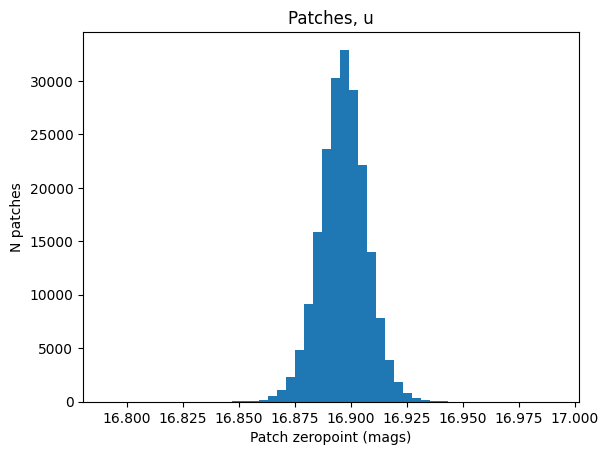

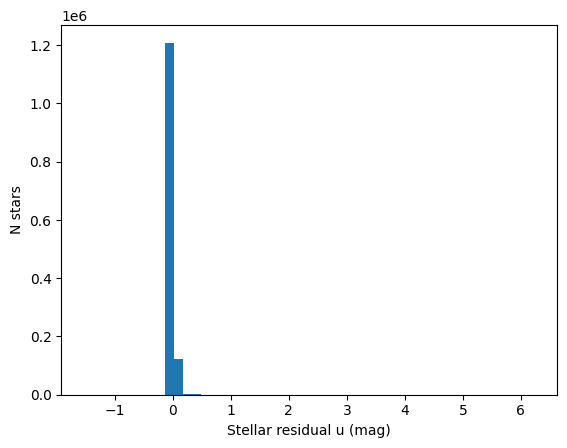

<Figure size 640x480 with 0 Axes>

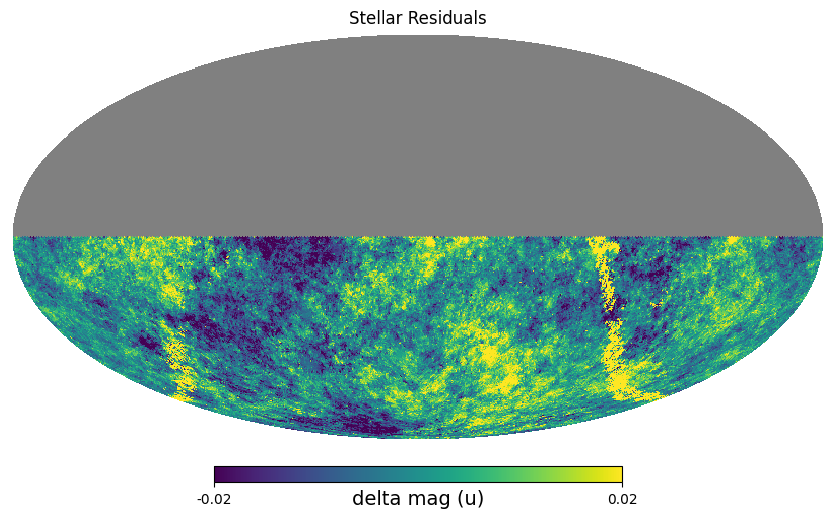

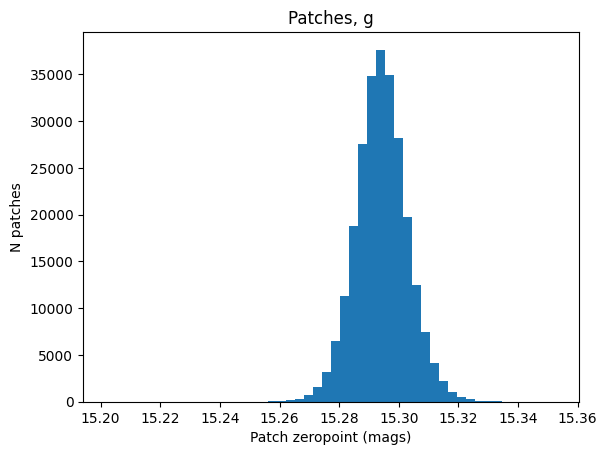

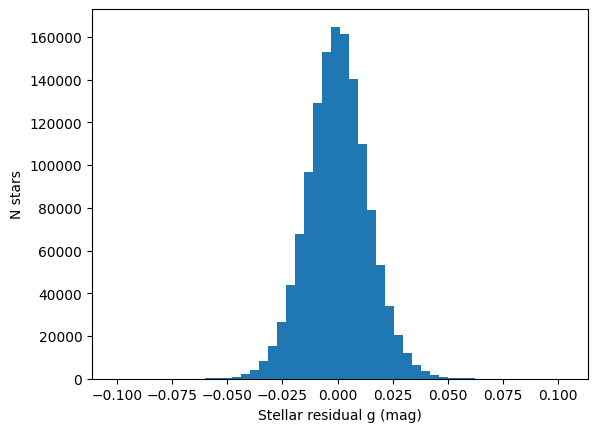

<Figure size 640x480 with 0 Axes>

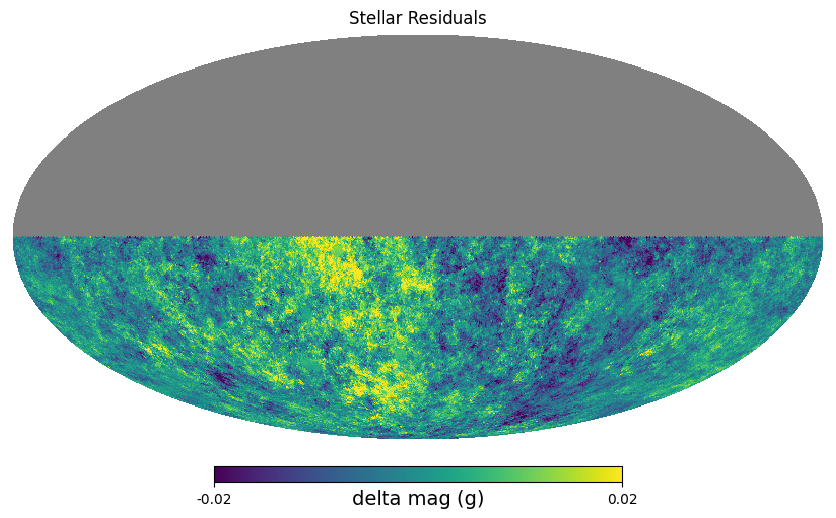

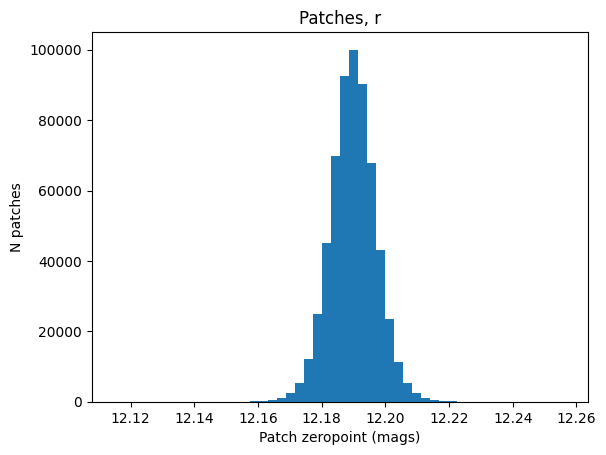

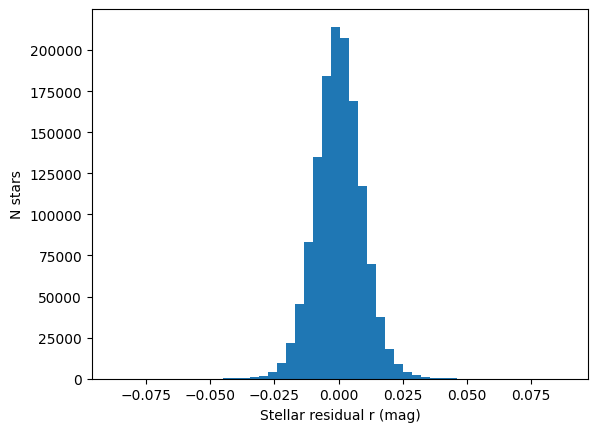

<Figure size 640x480 with 0 Axes>

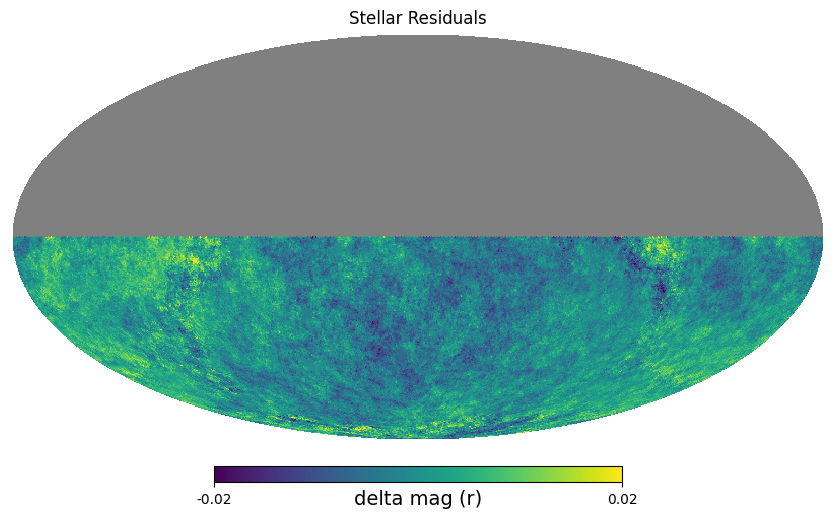

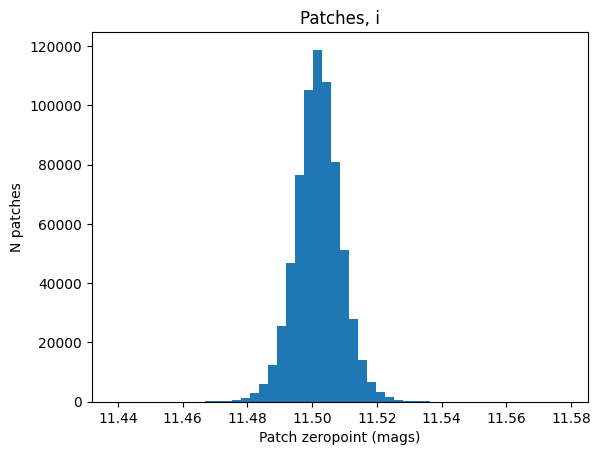

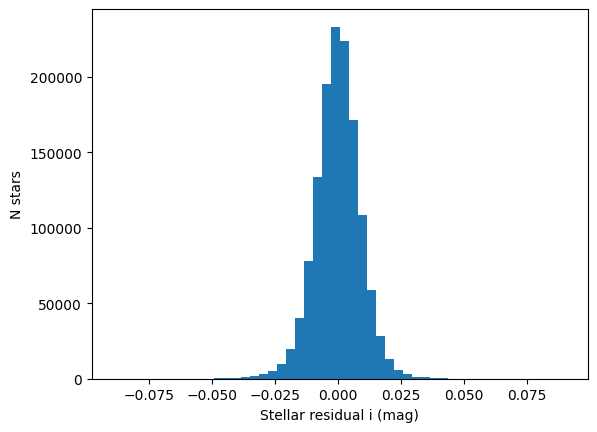

<Figure size 640x480 with 0 Axes>

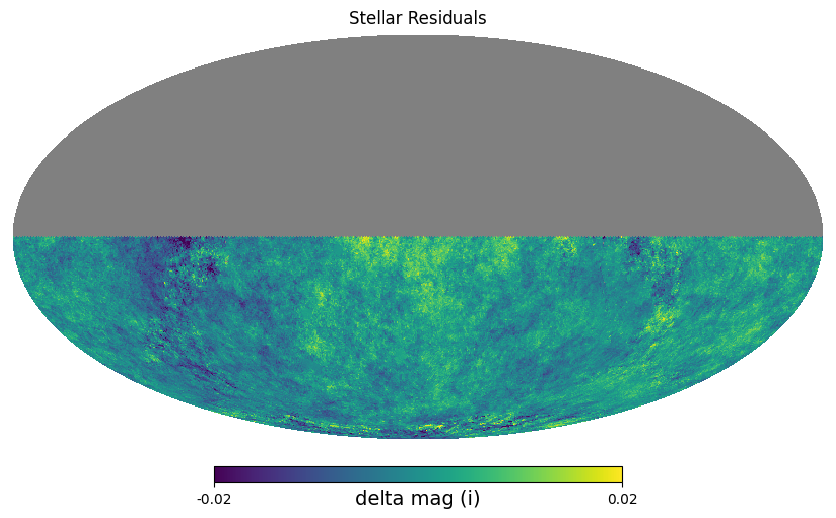

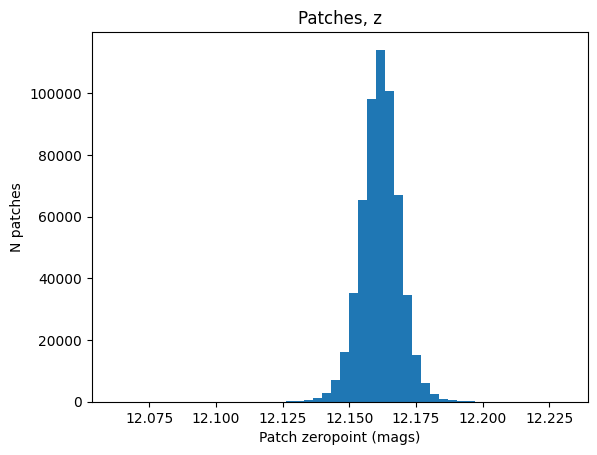

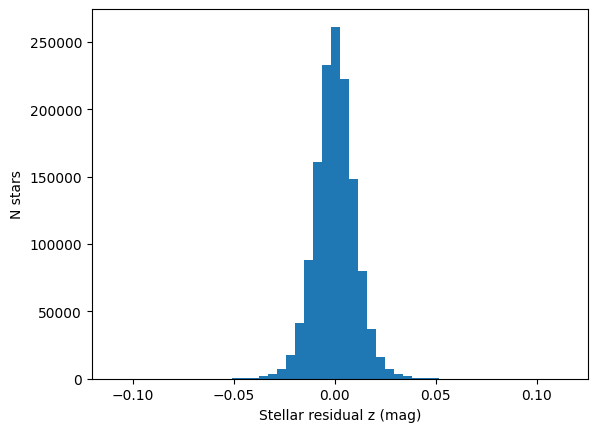

<Figure size 640x480 with 0 Axes>

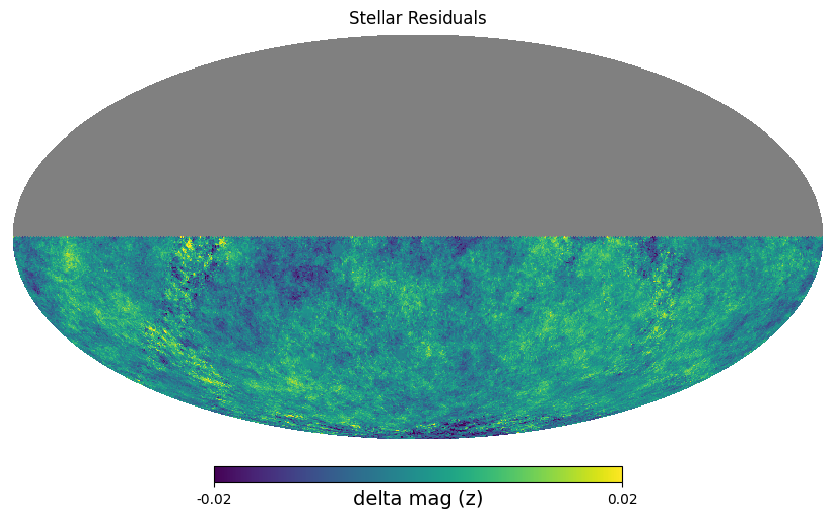

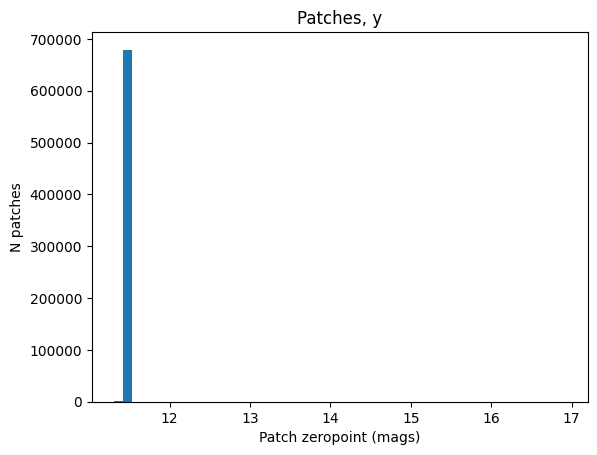

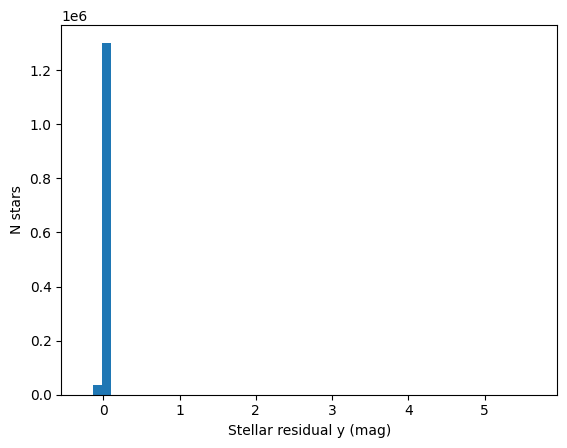

<Figure size 640x480 with 0 Axes>

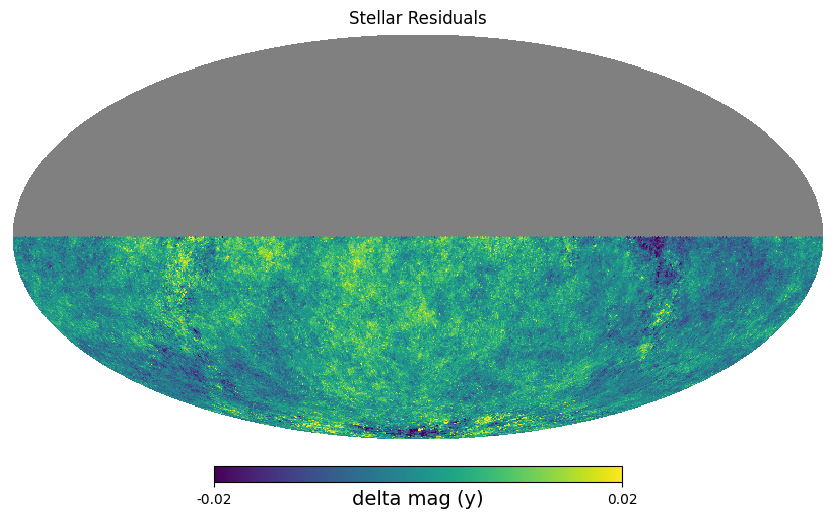

In [4]:
# load Rubin visit history from the baseline cadence simulation. Let's do year 1



all_resids = []

for filter_name in 'ugrizy':
    # Read the stars in
    con = sqlite3.connect("msrgb_1e6.sqlite")
    stars_df = pd.read_sql("select id,ra,decl,%smag from stars;" % filter_name, con)
    con.close()
    # Repackage as numpy array
    names = ['id', 'ra', 'decl', '%smag' % filter_name]
    types = [int, float, float, float]
    stars = np.empty(stars_df.shape[0], dtype=list(zip(names, types)))
    for key in names:
        stars[key] = stars_df[key].values

    con = sqlite3.connect(survey)
    # read with pandas
    visits_df = pd.read_sql("select observationId, fieldra as ra,fielddec as "
                            "dec,fiveSigmaDepth,rotSkyPos "
                            "from observations where filter='%s' and night < 365;" % filter_name, con)
    con.close()

    # Dump the dataframe into a simple numpy array. The to_numpy() method doesn't handle mixed dtypes well
    names = ['observationId', 'ra', 'dec', 'fiveSigmaDepth', 'rotSkyPos']
    types = [int, float, float, float, float]
    visits = np.empty(visits_df.shape[0], dtype=list(zip(names, types)))
    for key in names:
        visits[key] = visits_df[key].values

    offsets = [OffsetSys(error_sys=0.03), OffsetSNR(lsst_filter=filter_name)]

    observed_stars = generate_catalog(visits, stars, offsets=offsets,
                                      lsst_filter=filter_name, 
                                      n_patches=16, verbose=False)

    solver = LsqrSolver(observed_stars)

    t0 = time.time()

    solver.run()
    fit_patches, fit_stars = solver.return_solution()
    t1 = time.time()
    dt = (t1-t0)/60.
    print("%s runtime= %.1f min" % (filter_name, dt))

    plt.figure()
    _temp = plt.hist(fit_patches['zp'], bins=50)
    plt.xlabel('Patch zeropoint (mags)')
    plt.ylabel('N patches')
    plt.title('Patches, %s' % filter_name)

    # trim down truth stars to only the ones we got solutions for
    stars_trimmed = stars[np.in1d(stars['id'], fit_stars['id'])]

    # Residuals after fit, removing floating zeropoint
    resid = stars_trimmed['%smag' % filter_name] - fit_stars['fit_mag']
    resid = resid - np.median(resid) 

    plt.figure()
    _temp = plt.hist(resid, bins=50)
    plt.xlabel('Stellar residual %s (mag)' %filter_name)
    plt.ylabel('N stars')

    plt.figure()
    resid_map = healbin(stars_trimmed["ra"], stars_trimmed["decl"], resid, 128, reduce_func=np.mean)
    hp.mollview(resid_map, min=-0.02, max=0.02, title='Stellar Residuals', unit='delta mag (%s)' % filter_name)

    all_resids.append(resid)
